In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from mantid.simpleapi import LoadMD
from mantid import plots
from mantid.plots.helperfunctions import get_md_data

/SNS/software/miniconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib notebook

In [3]:
pwd

'/SNS/users/19g/notebooks/.rk-work/jnrk-sns-analysis-python3-default'

In [4]:
cd ~/builds/IPythonNotebookTutorial/solutions/

/SNS/users/19g/builds/IPythonNotebookTutorial/solutions


In [5]:
!ls ../Data/Fitting

HB1_exp0762_scan0072.dat  NaCl.npy  NaCl.nxs


A slice of data has already been created with Mantid.  So let's start there

In [6]:
MDdata = LoadMD('../Data/Fitting/NaCl.nxs')

Let's plot the data to see what it looks like.

<IPython.core.display.Javascript object>


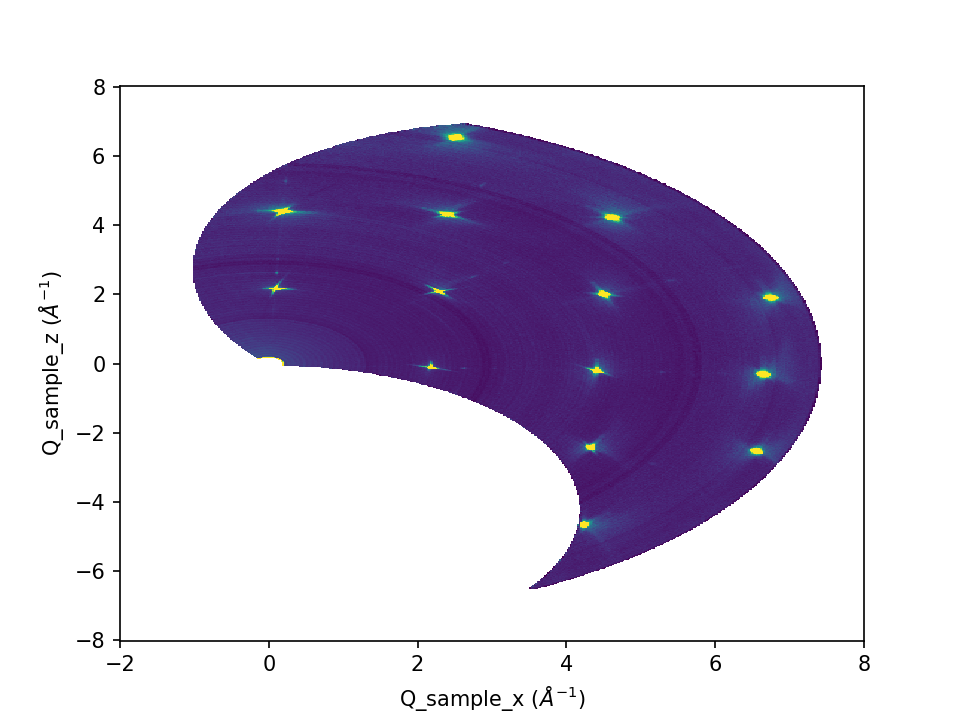

(-2, 8)

In [7]:
f,ax=plt.subplots(subplot_kw={'projection':'mantid'})
ax.pcolor(MDdata,vmax=1)
ax.set_xlim((-2,8))

To use the lmfit routines it is useful to extract the data from the mantid workspace and convert it into numpy arrays.
There is a conveient helper function for this. It returns the two axis values and the data and the errors

In [8]:
qs,dat,err=get_md_data(MDdata,None,withError=True)

In [9]:
dat.shape


(801, 801)

In [10]:
qs[0].shape


(802,)

note the shape of the x axis is one bigger than that dimesion of the data, so we need to get bin centers.
Fancy indexing can be used to convert edges to centers.

In [12]:
qx=(qs[0][1:]+qs[0][:-1])/2.
qy=(qs[1][1:]+qs[1][:-1])/2.

In [13]:
qx.shape

(801,)

Now we need an,x,y,I and err point for each data point.  We expand the x and y into a matrix using meshgrid

In [14]:
xmat,ymat=np.meshgrid(qx,qy)

Let's plot it to be sure we have the same thing

<IPython.core.display.Javascript object>


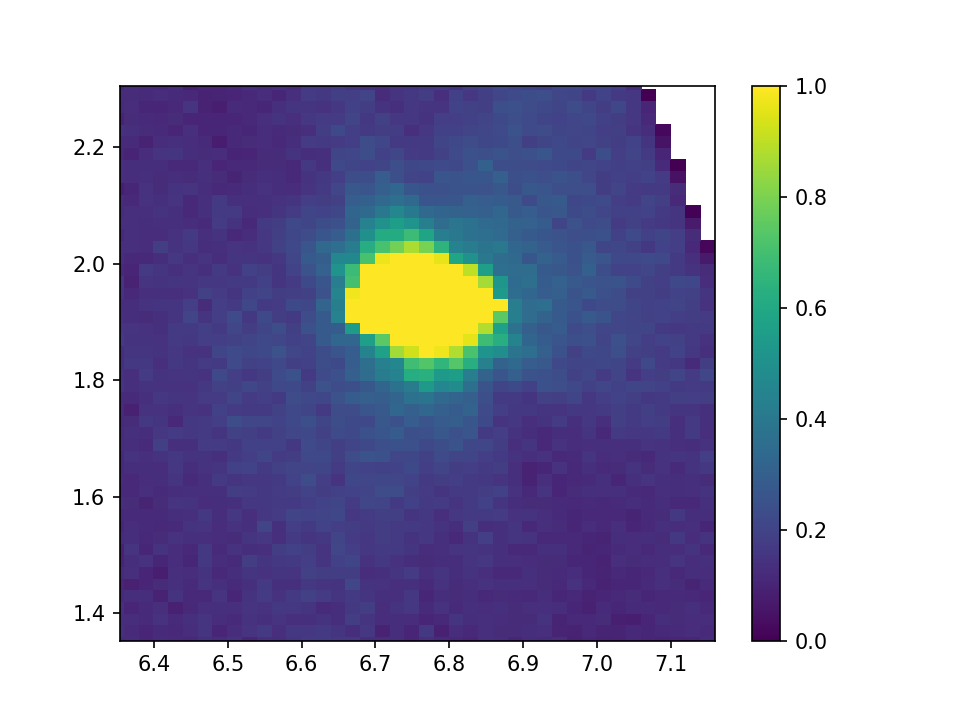

In [15]:
f1,ax1=plt.subplots()
cax=ax1.pcolor(xmat,ymat,dat,vmax=1)
f1.colorbar(cax)

Let's select one peak using the numpy where command. This command returns a tuple which in this case has only one dimension so we need the ```[0]``` to extract the element.

In [16]:
xidx=np.where((qx>6.4)&(qx<7.2))[0]
yidx=np.where((qy>1.6)&(qy<2.4))[0]

Let's print xidx to see what we have

In [20]:
xidx

array([720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745,
       746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759])

We will create the data sets needed for the fit by using the maximum and minimum of the indexes

In [18]:
dat_slice = dat[yidx.min():yidx.max(),xidx.min():xidx.max()]
err_slice = err[yidx.min():yidx.max(),xidx.min():xidx.max()]
xmat_slice = xmat[yidx.min():yidx.max(),xidx.min():xidx.max()]
ymat_slice = ymat[yidx.min():yidx.max(),xidx.min():xidx.max()]

In [66]:
xmat_slice.shape

(39, 39)

Now let's plot it to see what we have

<IPython.core.display.Javascript object>


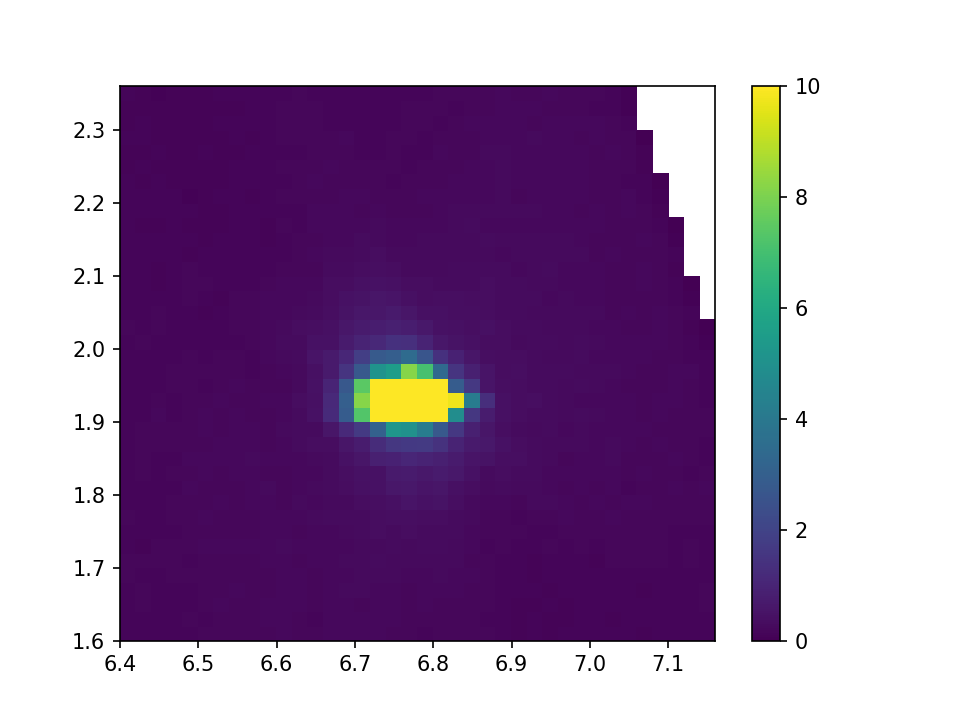

In [21]:
f1,ax=plt.subplots()
cax=ax.pcolor(xmat_slice,ymat_slice,dat_slice,vmax=10)
f1.colorbar(cax)

## Doing the fit ##
We will do the following steps
1. Define the fitting function
1. Delare the Model
1. Set the initial parameters and constraints
1. Do the fit
1. Print the result

First let's define the functions for fitting

first generate a rotation matrix around z

$R(\theta) = \begin{bmatrix}
cos(\theta) & -sin(\theta)\\
sin(\theta) & cos(\theta)\\
\end{bmatrix}$

In [22]:
def rotz(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

a 2d gaussian plus a background term

$\Sigma=\begin{bmatrix}
\sigma_1^2 & 0\\
0 & \sigma_2^2\\
\end{bmatrix}$

$X=[x,y]$

$\mu= [c_x,c_y]$

$G(x,y,A,\sigma_2,\sigma_2,\theta,c_x,c_y,b) = b+ \frac{A}{\sqrt{|\Sigma|}}e^{-\frac{1}{2}((R(X-\mu))^T\Sigma^{-1}R(X-\mu))}$

In [23]:
def Gauss2D(x,y,A,sig1,sig2,theta,cx,cy,b):
    xmax=len(x)
    X=np.vstack((x,y))
    Sigma=np.array([[sig1*sig1,0],[0,sig2*sig2]])
    Sigmainv=np.linalg.inv(Sigma)
    sqdetsig=np.sqrt(np.linalg.det(Sigma))
    mu=np.array([cx,cy])
    G=np.zeros(xmax)
    for idx in range(xmax):
       XmmuR=np.dot(rotz(theta),(X[:,idx]-mu))
       G[idx] =b+ A/sqdetsig*np.exp(-0.5*np.dot((XmmuR),np.dot(Sigmainv,(XmmuR))))
    return G

Set up the model declaring x and y to be independent variables

In [24]:
model=Model(Gauss2D,independent_vars=['x','y'])

Use the center of the slice as the starting point

In [25]:
cx=np.mean(xmat_slice)
cy=np.mean(ymat_slice)
print('cx = {}, cy = {}'.format(cx,cy))

cx = 6.780000193735187, cy = 1.9800000565775324


Setting the parameters is straight forward.  Note that constraints can be set.  Set the min and maximum value for theta.  This must be done because the rotation matrix produces a periodic result with $\theta$

In [26]:
model.set_param_hint('A',value=1)
model.set_param_hint('sig1',value=0.1)
model.set_param_hint('sig2',value=0.1)
model.set_param_hint('theta',value=0,min=0,max=np.pi/2.)
model.set_param_hint('cx',value=cx)
model.set_param_hint('cy',value=cy)
#model.set_param_hint('cx',value=6.8)
#model.set_param_hint('cy',value=2.0)
model.set_param_hint('b',value=0)

Do the fit. Note the fit is weighted by the errorbar.  
Lmfit only takes 1-D arrays the ravel command flattens the array.  ie it turns a multidimensional array into a 1-D array

In [27]:
result=model.fit(dat_slice.ravel(),x=xmat_slice.ravel(),y=ymat_slice.ravel(),weights=1./err_slice.ravel())

In [28]:
print(result.fit_report())

[[Model]]
    Model(Gauss2D)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 1521
    # variables        = 7
    chi-square         = 78.8841357
    reduced chi-square = 0.05210313
    Akaike info crit   = -4486.85673
    Bayesian info crit = -4449.56687
[[Variables]]
    A:      0.02777626 +/- 3.0800e-04 (1.11%) (init = 1)
    sig1:   0.03744487 +/- 3.2231e-04 (0.86%) (init = 0.1)
    sig2:   0.02388545 +/- 2.2150e-04 (0.93%) (init = 0.1)
    theta:  0.04505218 +/- 0.01280728 (28.43%) (init = 0)
    cx:     6.75784548 +/- 4.2505e-04 (0.01%) (init = 6.78)
    cy:     1.92085009 +/- 2.7105e-04 (0.01%) (init = 1.98)
    b:      0.17113706 +/- 0.00254820 (1.49%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(sig2, cy) =  0.106



<IPython.core.display.Javascript object>


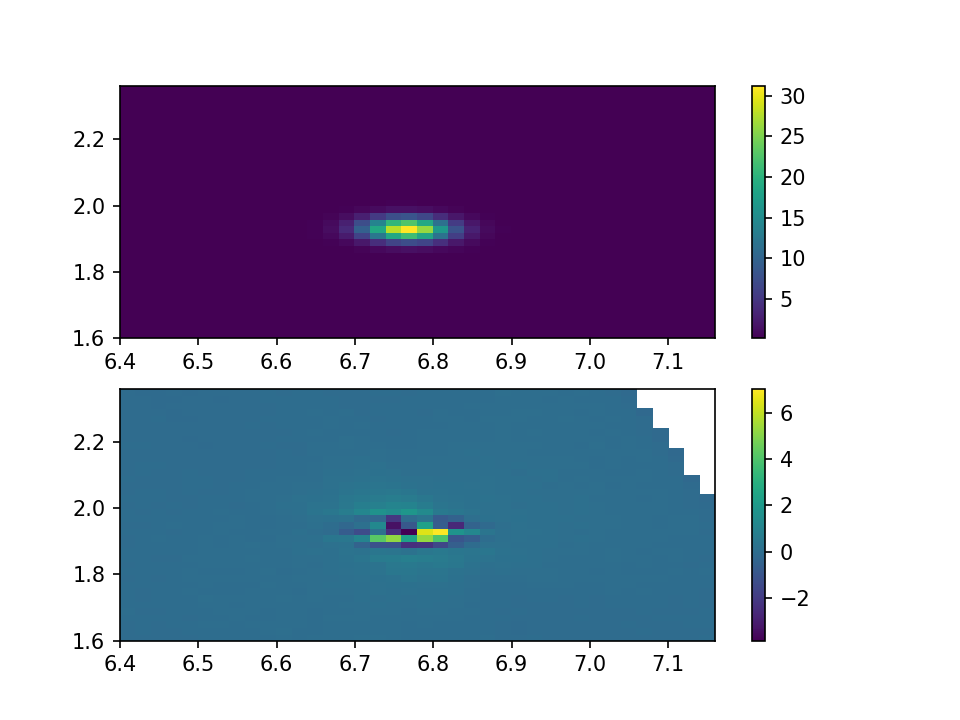

In [29]:
f3,ax3=plt.subplots(2,1)
c0=ax3[0].pcolor(xmat_slice,ymat_slice,result.best_fit.reshape(xmat_slice.shape))
c1=ax3[1].pcolor(xmat_slice,ymat_slice,dat_slice-result.best_fit.reshape(xmat_slice.shape))
f3.colorbar(c0,ax=ax3[0])
f3.colorbar(c1,ax=ax3[1])

let's try it without constraining theta and start theta well away from zero

In [52]:
model.set_param_hint('theta',value=np.pi/2.,max=np.inf)

In [53]:
result2=model.fit(dat_slice.ravel(),x=xmat_slice.ravel(),y=ymat_slice.ravel(),weights=1./err_slice.ravel())

In [73]:
print(result2.fit_report())

[[Model]]
    Model(Gauss2D)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 116
    # data points      = 1521
    # variables        = 7
    chi-square         = 78.8841378
    reduced chi-square = 0.05210313
    Akaike info crit   = -4486.85669
    Bayesian info crit = -4449.56683
[[Variables]]
    A:      0.02777632 +/- 3.0800e-04 (1.11%) (init = 1)
    sig1:   0.02388666 +/- 2.2153e-04 (0.93%) (init = 0.1)
    sig2:   0.03744512 +/- 3.2231e-04 (0.86%) (init = 0.1)
    theta:  42846.6565 +/- 0.01282225 (0.00%) (init = 1.570796)
    cx:     6.75784502 +/- 4.2505e-04 (0.01%) (init = 6.78)
    cy:     1.92085071 +/- 2.7107e-04 (0.01%) (init = 1.98)
    b:      0.17113649 +/- 0.00254820 (1.49%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(sig1, cy) =  0.106



## Exercise
Pick another peak and try fitting that one

There is a more elegant way to choose the points using "broadcasting" see https://jakevdp.github.io/PythonDataScienceHandbook/02.07-fancy-indexing.html or https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

The trick is to use broadcasting rules to get 2D arrays.First we create a column vector

In [72]:
yidx[:,np.newaxis]

array([[480],
       [481],
       [482],
       [483],
       [484],
       [485],
       [486],
       [487],
       [488],
       [489],
       [490],
       [491],
       [492],
       [493],
       [494],
       [495],
       [496],
       [497],
       [498],
       [499],
       [500],
       [501],
       [502],
       [503],
       [504],
       [505],
       [506],
       [507],
       [508],
       [509],
       [510],
       [511],
       [512],
       [513],
       [514],
       [515],
       [516],
       [517],
       [518],
       [519]])

Then we use a column vector and row vector for the indexes.  This gives us 2d arrays

In [69]:
dat_slice = dat[yidx[:,np.newaxis],xidx]
err_slice = err[yidx[:,np.newaxis],xidx]
xmat_slice = xmat[yidx[:,np.newaxis],xidx]
ymat_slice = ymat[yidx[:,np.newaxis],xidx]

<IPython.core.display.Javascript object>


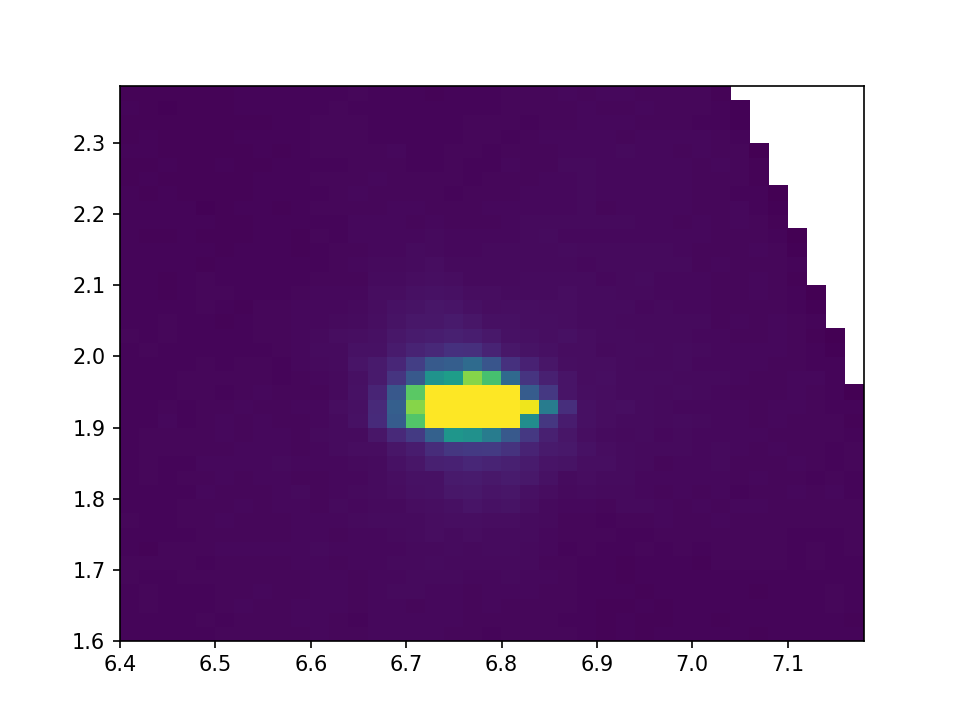

In [70]:
f3,ax3=plt.subplots()
cax=ax3.pcolormesh(xmat_slice,ymat_slice,dat_slice,vmax=10)